## Importing Libraries

In [181]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [182]:
df = pd.read_csv(r'C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\New Extraction\Data\Biden_No_Retweet_Full_Text.csv',error_bad_lines=False)

In [183]:
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15098 non-null  object
 1   Tweet_id   15098 non-null  int64 
 2   Verified   15098 non-null  bool  
 3   Tweet      15098 non-null  object
 4   User       15098 non-null  object
 5   Location   11032 non-null  object
 6   Source     15098 non-null  object
 7   Likes      15098 non-null  int64 
 8   Followers  15098 non-null  int64 
 9   Following  15098 non-null  int64 
 10  Retweets   15098 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [185]:
df.shape

(15098, 11)

# Data Preprocessing & Cleaning

The Date column is an object type. Let us convert it to datetime using datetime module.

In [186]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [187]:
df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

Let us check for any null values in our dataset

In [188]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4066
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

The location column has upto 4066 values as null. This may be the case since many users didn't voluntarily put it up. However this is not of much concern for our project. Hence we would leave it to null only

In [189]:
df['Source'].value_counts()

Twitter Web App                     5910
Twitter for iPhone                  4565
Twitter for Android                 3267
Twitter for iPad                     705
TweetDeck                            150
                                    ... 
Restream.io                            1
Pullquote: save and share quotes       1
Twitter for Advertisers                1
RunnerCommonKeys                       1
Bitly                                  1
Name: Source, Length: 87, dtype: int64

About 10,000 users tweeted from the web app & from iphone

In [190]:
df['Location'].nunique()

3200

Tweets gathered were from 3200 different locations around the world.

In [191]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

15098

In [192]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

15046

There seems to be some duplicates in our dataset. Let us remove these using the set function

In [193]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [194]:
df['Tweet'].duplicated().sum()

52

In [195]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(15046, 11)

Removed all the duplicates using the drop_duplicates function

In [196]:
df['Tweet'].duplicated().sum()

0

### Remove Emojis

In [197]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df['Processed_Tweet']=df.Tweet.apply(remove_emoji)


From now on, all the preprocessing & modelling on tweets will be stored in the data column called 'Processed_Tweet'

In [198]:
count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

0

The above code is to ensure that there are no retweets in our dataset. Using Regex, this has been confirmed.

In [199]:
df.shape

(15046, 12)

In [200]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

### Remove Retweets

In [201]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [202]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Remove Usernames

In [203]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [204]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Remove Any URLs 

In [205]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [206]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Removing Hashtags & Keeping The Word

In [207]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [208]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        GeorgeWill , it’s so sad you wake up everyday ...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 Biden formally implicated in Ukrain...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [209]:
import preprocessor as p #Module for faster preprocessing specifically for tweets

In [210]:
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [211]:
df['Processed_Tweet']

0        VP Biden I wish you wouldn't debate Trump unle...
1        GeorgeWill , its so sad you wake up everyday f...
2        Question:If doesnt pick a woman of color, woul...
3        Right? Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Removing Any Special Characters, Numbers, Punctuations etc.

In [212]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")


In [213]:
df["Processed_Tweet"]

0        VP Biden I wish you wouldn t debate Trump unle...
1        GeorgeWill   its so sad you wake up everyday f...
2        Question If doesnt pick a woman of color  woul...
3        Right  Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants  W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don t want to leave out the left  Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls  Why Biden s  Nationwide Lead  Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [214]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 

In [215]:
df["Processed_Tweet"]

0        vp biden i wish you wouldn t debate trump unle...
1        georgewill   its so sad you wake up everyday f...
2        question if doesnt pick a woman of color  woul...
3        right  biden formally implicated in ukraine sc...
4        these idiots let trump do anything he wants  w...
                               ...                        
15041    other than going big by eulogizing stromthurmo...
15042    don t want to leave out the left  show your su...
15043    some chatter about biden maybe activating reso...
15044    fake polls  why biden s  nationwide lead  over...
15045    joe biden trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [216]:
df.Processed_Tweet =  df.Processed_Tweet.str.replace("amp", "")

In [217]:
df['Processed_Tweet'][12] #Sample tweet

'biden took know questions so he could tell you know lies  of course the lies would make absolutely no sense because he has no idea where he is or what hes doing  incontinent twit '

# EDA

In [218]:
df['User'].value_counts()

Hotpage_News      544
jacketrose86      174
mobygrapefan       71
defeatthedevil     67
deepen915          61
                 ... 
ReBiE88             1
srjaffe8            1
T_Kremin            1
Trevorlavy          1
gbponz              1
Name: User, Length: 8270, dtype: int64

A whopping 544 tweets from Hotpage_News. This seems to be an account owned by an organization. Let us have a look at jacketrose86.

In [219]:
df.query('User == "jacketrose86"').Processed_Tweet.tolist()

['the can be no order when the laws remain unjust  trump s tyranny runs rant while we die by the thousands   vote joe   liar  liar pants on fire  you re on the wrong side i d history  fk donniedollhands cheetomcasshat biden    landslide istandwithfauci fauciisahero biden',
 'it is our duty to protect the world from trump  we can t let him win another term  donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'there are more reasons to not vote for him  staying alive is one of them  biden cares if we live or die   fk donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'aww thanks for adding me fk donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'thanks so much   have some snacks for cocktail hour  they re about the same size as his co

A manual inspection clearly indicates a negative sentiment towards the candidature of Joe Biden

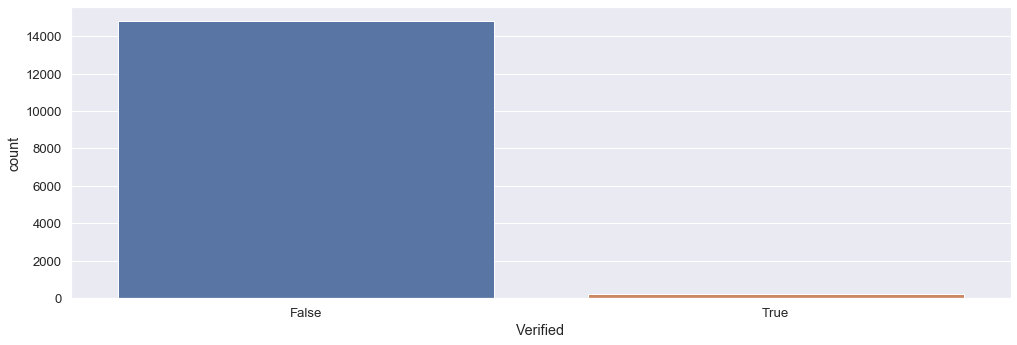

In [220]:
bar = sns.countplot(df['Verified'])

In [221]:
df['Verified'].value_counts()

False    14830
True       216
Name: Verified, dtype: int64

Only 216 verified accounts were extracted. This shouldn't be a problem while calculating our sentiment.

In [222]:
df_verified = df.query('Verified == True')


In [223]:
df_verified['User'].value_counts()

AndyOstroy       15
JudicialWatch     9
DemsAbroad        7
The_NewArab       7
Varneyco          7
                 ..
aawsat_eng        1
kwtx              1
RiceUNews         1
debbiewfleck      1
TarekFatah        1
Name: User, Length: 121, dtype: int64

A user by the name AndyOstroy has 15 tweets about Joe Biden in the time-period of extraction. Let us look at some of his tweets.

In [224]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['its intellectually dishonest  and quite hypocritical  for liberals who preach unity and bipartisanship to be losing their damn minds because one republican is gonna speak at the democratic convention    johnkasich kasich biden',
 'we are now at a new cray cray low in the trump presidency where he s challenged biden to a duel to see who can  ace  the  is this a lion or a monkey   cognitive test    chriswallace',
 'humiliating   historic    landslide  its coming     trump election     biden',
 'hey like how you cried daddy  daddy  please dont let them make me go to vietnam  before he bought you those deferments  coward    trump chriswallace biden',
 'how do you feel about susanrice as biden s vp ',
 'i believe on nov rd were going to witness the biggest  most humiliating  most historic backlash against and republicans this country has ever seen and could ever have imagined    election     biden trump',
 'hey moron   all of this darkness  despair  dysfunction  disease  death you re show

He seems to be very angry towards Joe Biden & clearly has no positive sentiment 

Let us look at another, JudicialWatch

In [225]:
df_verified.query('User == "JudicialWatch"').Processed_Tweet.tolist()

['judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensively while receiving a secret service protective detail  read ',
 '  president  theres no lawful reason for the university of delaware to withhold biden records  read more at',
 ' judicial watch investigators uncovered records from the u s  secret service showing that  for the first and a half years of the obama admin  hunter biden traveled extensively with a secret service protective detail  in newsmax  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensively while receiving a secret service protective detail  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensi

On manual inspection, there seems to be sentiment towards Joe Biden. Can be classified as a Neutral user.

Let us observe the dates & how they fair out. Let us observe how many tweets were extracted on which date

In [226]:
days = df['Date'].dt.day.tolist()

In [227]:
no_of_days = Counter(days)
no_of_days

Counter({21: 2084,
         20: 1862,
         19: 1712,
         18: 1322,
         17: 1573,
         16: 1638,
         15: 2020,
         14: 1884,
         13: 951})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

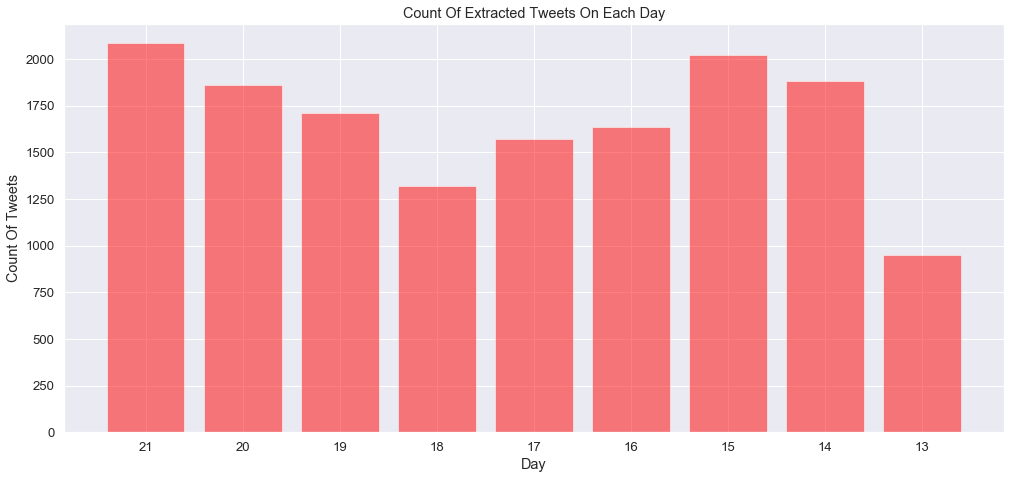

In [228]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

We had a maximum of approx 2000 tweets extracted on the 21st July & the 15th of July.

Let us also look at the times (hours) at which the most tweets were extracted.

In [229]:
hours = df['Date'].dt.hour.tolist()

In [230]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 857,
         22: 917,
         21: 891,
         20: 829,
         19: 828,
         18: 1107,
         17: 938,
         16: 953,
         15: 867,
         14: 834,
         13: 740,
         12: 560,
         11: 423,
         10: 260,
         9: 156,
         8: 157,
         7: 198,
         6: 237,
         5: 290,
         4: 397,
         3: 475,
         2: 628,
         1: 780,
         0: 724})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

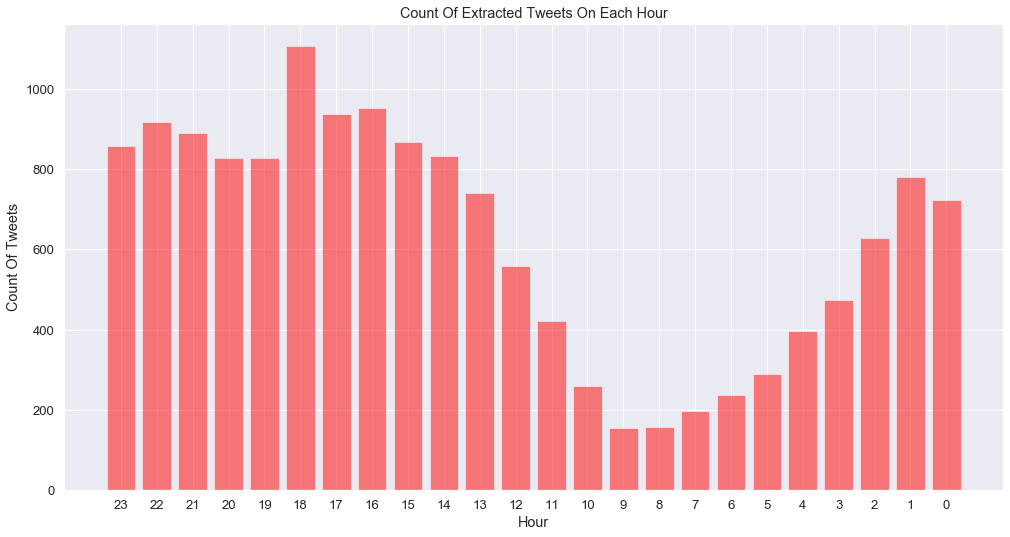

In [231]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

Lots of tweets at the 18:00 - 19:00 hour period followed by 16:00 - 17:00 hour

In [232]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()


We still have to remove stopwords, perform lemmatization & do stemming. So let us proceed with that

### Removing Stop Words

In [233]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words)

["hadn't", 'it', "you'll", 'when', "didn't", 'now', 'for', 'because', 'here', 'but', 'no', 'ourselves', "haven't", 'ain', 'needn', 'weren', 'couldn', 'while', 'too', 'over', 'wasn', "weren't", 'very', "don't", 'their', 'we', 'against', 'under', 'd', 'yourselves', 'was', 'theirs', 'an', 'do', 'myself', 'which', 's', 'll', "mightn't", 'a', 'doing', 'me', 'nor', 'y', 'down', 'am', "she's", "you've", 'were', 'all', 'only', "won't", "you're", 'will', 'who', 'then', 'are', 'those', 'm', 'into', 'where', 'there', 'yours', 'and', "shouldn't", 'how', 'any', "it's", 'with', 'does', 'above', 'other', 'wouldn', 'ours', 've', 'up', 'they', 'what', 'during', 'hers', 'below', 'his', 'having', 'to', 'herself', 'mustn', 'my', 'both', 'them', 'that', 'i', 'or', 'about', 'haven', 'you', 'most', 'mightn', "wasn't", 'her', 'did', 'our', 'has', "isn't", 're', 'why', 'won', 'the', 'of', 'same', 'out', 'as', 'shouldn', 'such', 'being', 'is', 'at', 'few', "shan't", 'if', 'before', 'themselves', "doesn't", 'o',

In [234]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords

In [235]:
df['Processed_Tweet']

0        vp biden wish debate trump unless debate trump...
1        georgewill sad wake everyday forgetting george...
2        question doesnt pick woman color would black c...
3        right biden formally implicated ukraine scanda...
4        idiots let trump anything wants biden gets ele...
                               ...                        
15041    going big eulogizing stromthurmond look right ...
15042    want leave left show support election hearts f...
15043    chatter biden maybe activating resources fight...
15044    fake polls biden nationwide lead trump says no...
15045                   joe biden trump police armed teeth
Name: Processed_Tweet, Length: 15046, dtype: object

## Tokenizing

In [236]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x))

In [237]:
df['Processed_Tweet']

0        [vp, biden, wish, debate, trump, unless, debat...
1        [georgewill, sad, wake, everyday, forgetting, ...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formally, implicated, ukraine, ...
4        [idiots, let, trump, anything, wants, biden, g...
                               ...                        
15041    [going, big, eulogizing, stromthurmond, look, ...
15042    [want, leave, left, show, support, election, h...
15043    [chatter, biden, maybe, activating, resources,...
15044    [fake, polls, biden, nationwide, lead, trump, ...
15045            [joe, biden, trump, police, armed, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

## Stemming 

In [238]:
#Perform stemming 
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(text)

In [239]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [240]:
df['Processed_Tweet']

0        [vp, biden, wish, debat, trump, unless, debat,...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [go, big, eulog, stromthurmond, look, right, l...
15042    [want, leav, left, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

In [241]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [242]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru..."
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg..."
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ..."
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal..."
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,..."
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,NaN,Twitter Web App,0,1,0,0,"[want, leav, left, show, support, elect, heart..."
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ..."
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,NaN,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa..."


Creating strings for each tweet for putting in the model

In [243]:
texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [244]:
all_words = []
for i in texts:
    all_words.append(" ".join(i))
    


In [245]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [246]:
len(text)

227438

In [247]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

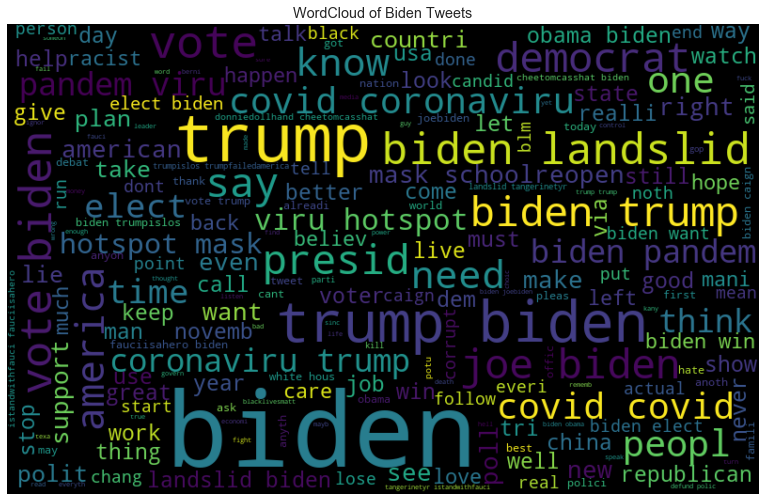

In [248]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

## Sentiment Analysis

In [249]:
from textblob import TextBlob

In [250]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [251]:
len(pol)

15046

In [252]:
len(text)

227438

In [253]:
df['Processed_Tweet']

0        [biden, wish, debat, trump, unless, debat, tru...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [big, eulog, stromthurmond, look, right, look,...
15042    [want, leav, left, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

Classifying tweets as neutral, positive, negative

In [254]:
positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 5953
Negative Tweets: 3050
Neutral Tweets 6043


In [255]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ROSHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [256]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])
#sentimental_score = pd.DataFrame(list(sentiment_scores))
#sentimental_score.tail(12)


In [257]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))



In [258]:
sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.214,0.619,0.167,-0.3612
1,0.204,0.694,0.102,-0.3612
2,0.000,1.000,0.000,0.0000
3,0.266,0.734,0.000,-0.4404
4,0.148,0.493,0.359,0.4019
...,...,...,...,...
15041,0.180,0.820,0.000,-0.6808
15042,0.000,0.810,0.190,0.4588
15043,0.206,0.794,0.000,-0.6369
15044,0.121,0.623,0.257,0.5423


In [259]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.214,0.619,0.167,-0.3612,Negative
1,0.204,0.694,0.102,-0.3612,Negative
2,0.000,1.000,0.000,0.0000,Neutral
3,0.266,0.734,0.000,-0.4404,Negative
4,0.148,0.493,0.359,0.4019,Positive


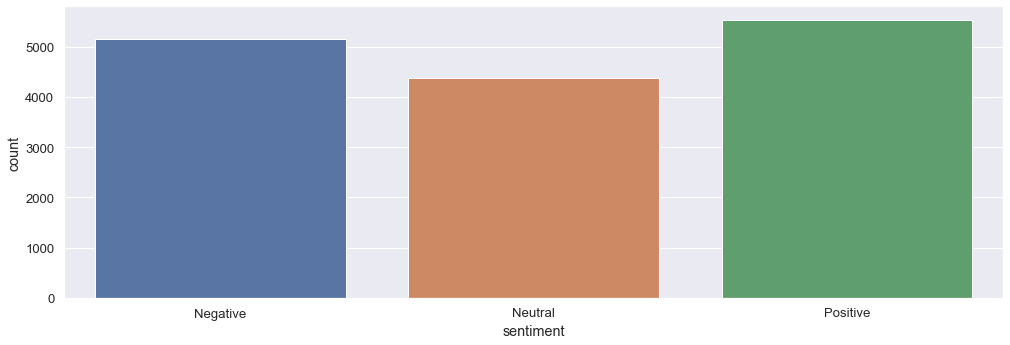

In [260]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [261]:
filepath = r"C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [262]:
emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [263]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association
    

In [264]:
for i in range(0,15046):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [265]:
emotions

{'positive': 5752.0,
 'negative': 5936.0,
 'surprise': 1491.0,
 'sadness': 2759.0,
 'anger': 3044.0,
 'joy': 1994.0,
 'trust': 3538.0,
 'fear': 3265.0,
 'anticipation': 2296.0,
 'disgust': 1944.0}

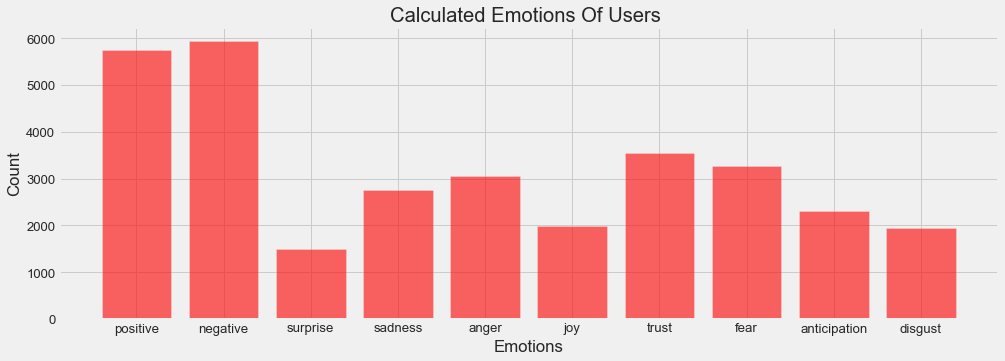

In [266]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [267]:
df.Location  = df.Location.fillna('USA')

In [268]:
f = [i for i in df['Location'] if type(i) != str]
f

[]

In [269]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))

In [270]:
df.Location.value_counts()

USA                               5487
First star to the right            174
Florida, USA                       158
Washington, DC                     157
Earth                              136
                                  ... 
Public School                        1
Banjul, Gambia                       1
NY to MA to Arizona. USA             1
near FDR Park                        1
Denver, Colorado or somewhere        1
Name: Location, Length: 3195, dtype: int64

In [271]:
locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,...",Fort Worth
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,USA,Twitter Web App,0,1,0,0,"[want, leav, left, show, support, elect, heart...",USA
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ...",Lehigh Valley
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,USA,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa...",USA


In [272]:
df1 = df

In [273]:
df1['sentiment'] = sentimental_score_df['val']

In [274]:
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA,Negative
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora,Negative
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville,Neutral
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA,Negative
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory,Positive


In [275]:
df1.to_csv('Location.csv',index = False)

In [276]:
df1['day'] = df.Date.dt.day
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA,Negative,21
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora,Negative,21
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville,Neutral,21
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA,Negative,21
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory,Positive,21


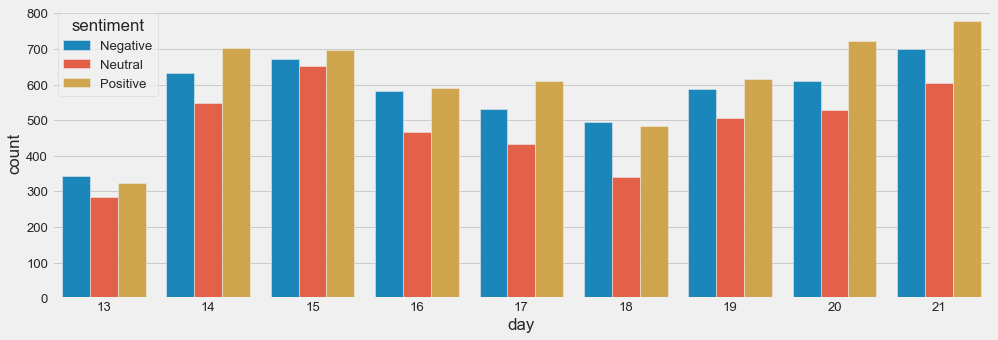

In [277]:
sns.countplot(df['day'],hue = df['sentiment'])

In [278]:
#df1.to_excel("output.xlsx") 

## Predictions

In [279]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [280]:
le = LabelEncoder() 
  
df1['sentiment_1']= le.fit_transform(df1['sentiment']) 

In [281]:
df1

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day,sentiment_1
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,USA,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru...",USA,Negative,21,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg...",East Aurora,Negative,21,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ...",Nashville,Neutral,21,1
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,USA,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal...",USA,Negative,21,0
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e...",Purgatory,Positive,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,...",Fort Worth,Negative,13,0
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,USA,Twitter Web App,0,1,0,0,"[want, leav, left, show, support, elect, heart...",USA,Positive,13,2
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ...",Lehigh Valley,Negative,13,0
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,USA,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa...",USA,Positive,13,2


In [282]:
#from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the vectorizer 
#vect = TfidfVectorizer(ngram_range=(1,1), max_features=1500).fit(all_words)

# Transform the vectorizer
#X_tfidf = vect.transform(all_words).toarray()


In [283]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(all_words).toarray()
y = df1['sentiment_1']

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# NEGATIVE == 0
# NEUTRAL == 1
# POSITIVE == 2

In [285]:
#X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3, random_state = 0)

# Decision Tree

In [286]:
classifier_DT = DecisionTreeClassifier()
classifier_DT.fit(X_train, y_train)
y_pred_DT = classifier_DT.predict(X_test)

In [287]:
accuracy_score_DT = accuracy_score(y_test, y_pred_DT)
precision_score_DT = precision_score(y_test, y_pred_DT , average = 'micro')
recall_score_DT = recall_score(y_test, y_pred_DT , average = 'micro')
f1_score_DT = f1_score(y_test, y_pred_DT , average = 'micro')
print("Accuracy Score: " , accuracy_score_DT)
print("Precision Score: " , precision_score_DT)
print("Recall Score: " , recall_score_DT)
print("F1 Score: " , f1_score_DT)

Accuracy Score:  0.8139122729286664
Precision Score:  0.8139122729286664
Recall Score:  0.8139122729286664
F1 Score:  0.8139122729286664


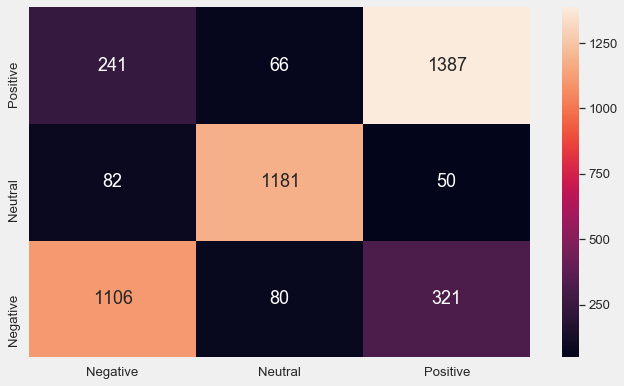

In [288]:
cm_DT = confusion_matrix(y_test, y_pred_DT)

      # neg # neutr  # pos
# pos # 1106   83      318
# neu #  93   1172     48
# neg # 258    69      1367

df_cm_DT = pd.DataFrame(cm_DT, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_DT, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories ,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Hyperparameter tuning

In [289]:
#params = {'criterion': ['gini','entropy'],'splitter':['best','random'],'max_leaf_nodes': list(range(2,10)), 'min_samples_split': [2, 3, 4]}
#grid_search_cv = GridSearchCV(classifier, params,cv=3)
#grid_search_cv.fit(X_train, y_train)

In [290]:
#grid_search_cv.best_params_

In [291]:
#y_pred_acc = grid_search_cv.predict(X_test)

In [292]:
#cross_val_score( grid_search_cv, y_test, y_pred_acc, cv=3)

## Random Forest

In [293]:
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

C:\Users\ROSHAN\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [294]:
accuracy_score_RF = accuracy_score(y_test, y_pred_RF)
precision_score_RF = precision_score(y_test, y_pred_RF , average = 'micro')
recall_score_RF = recall_score(y_test, y_pred_RF, average = 'micro')
f1_score_RF = f1_score(y_test, y_pred_RF, average = 'micro')
print("Accuracy Score: " , accuracy_score_RF)
print("Precision Score: " , precision_score_RF)
print("Recall Score: " , recall_score_RF)
print("F1 Score: " , f1_score_RF)

Accuracy Score:  0.8478068232166592
Precision Score:  0.8478068232166592
Recall Score:  0.8478068232166592
F1 Score:  0.8478068232166592


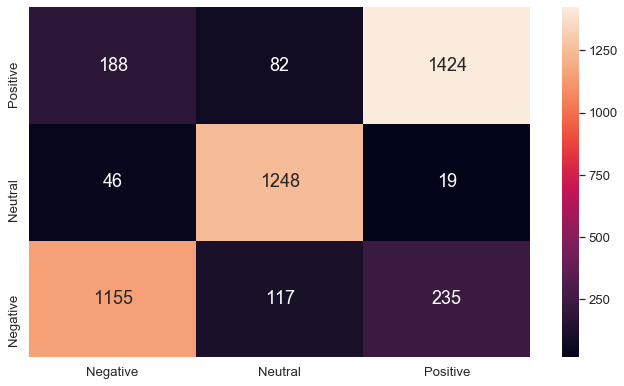

In [295]:
cm_RF = confusion_matrix(y_test, y_pred_RF)

      # neg # neutr  # pos
# pos # 204    106     1384
# neu #  58   1227      28
# neg # 1118   123     266

df_cm_RF = pd.DataFrame(cm_RF, range(3), range(3))
categories = ['Negative','Neutral','Positive']
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_RF, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Naive Bayes

In [296]:
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)
y_pred_NB = classifier_NB.predict(X_test)

In [297]:
accuracy_score_NB = accuracy_score(y_test, y_pred_NB)
precision_score_NB = precision_score(y_test, y_pred_NB , average = 'micro')
recall_score_NB = recall_score(y_test, y_pred_NB, average = 'micro')
f1_score_NB = f1_score(y_test, y_pred_NB, average = 'micro')
print("Accuracy Score: " , accuracy_score_NB)
print("Precision Score: " , precision_score_NB)
print("Recall Score: " , recall_score_NB)
print("F1 Score: " , f1_score_NB)

Accuracy Score:  0.682986264953478
Precision Score:  0.682986264953478
Recall Score:  0.682986264953478
F1 Score:  0.682986264953478


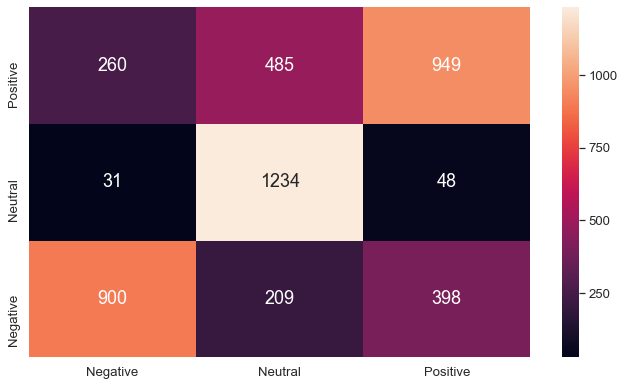

In [298]:
cm_NB = confusion_matrix(y_test, y_pred_NB)

      # neg # neutr  # pos
# pos # 260    485     949
# neu #  31   1234     48
# neg # 900   209     498

df_cm_NB = pd.DataFrame(cm_NB, range(3), range(3))
plt.figure(figsize=(10,6))
categories = ['Negative','Neutral','Positive']
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm_NB, annot=True, annot_kws={"size": 18}, xticklabels = categories,
            yticklabels = categories,fmt="d") # font size
plt.ylim(0, 3)
plt.show()

## Comparing The Models

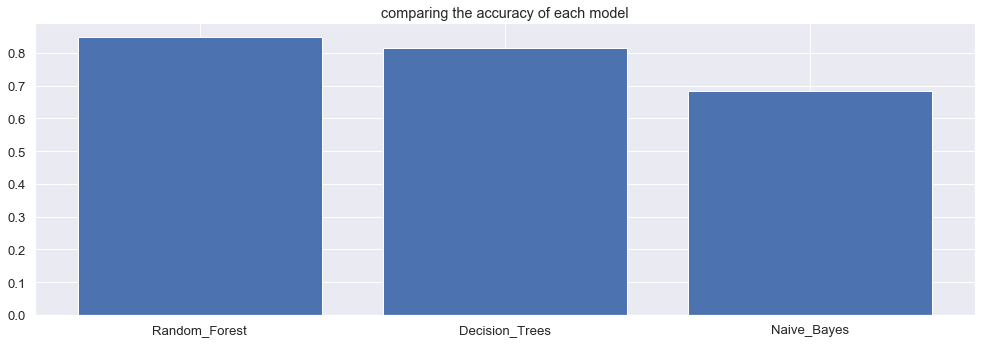

In [299]:
Accuracy = [accuracy_score_RF, accuracy_score_DT, accuracy_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Accuracy_pos = np.arange(len(Methods))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Methods)
plt.title('comparing the accuracy of each model')
plt.show()

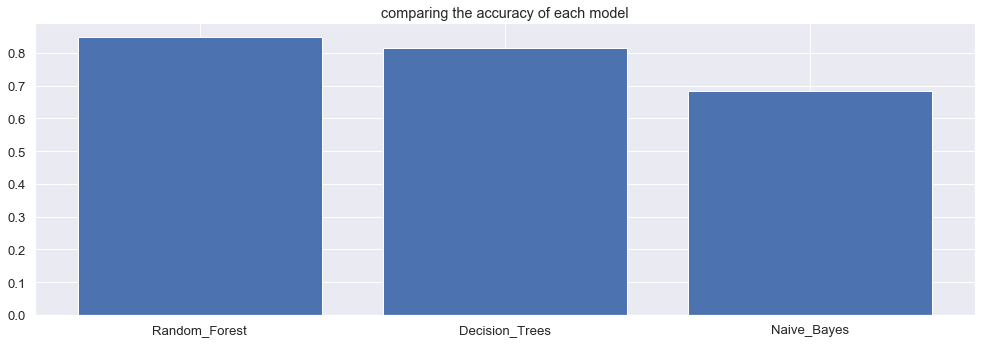

In [300]:
Precision = [precision_score_RF, precision_score_DT, precision_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Precision_pos = np.arange(len(Methods))
plt.bar(Precision_pos, Precision)
plt.xticks(Precision_pos, Methods)
plt.title('comparing the accuracy of each model')
plt.show()

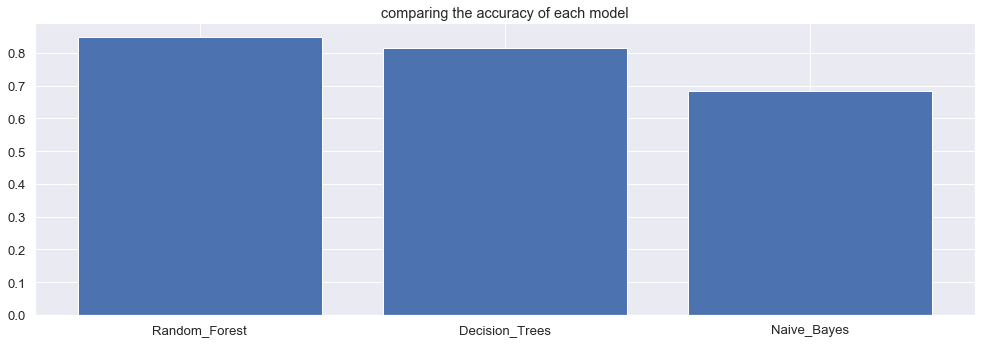

In [301]:
Recall = [recall_score_RF, recall_score_DT, recall_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
Recall_pos = np.arange(len(Methods))
plt.bar(Recall_pos, Recall)
plt.xticks(Recall_pos, Methods)
plt.title('comparing the accuracy of each model')
plt.show()

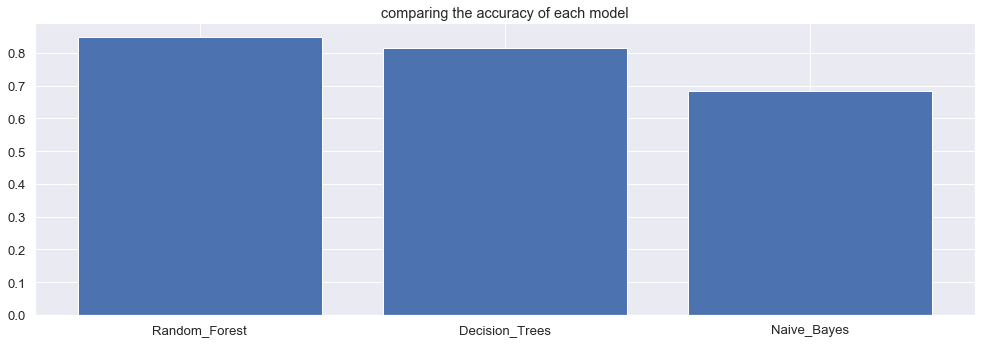

In [302]:
F1 = [f1_score_RF,f1_score_DT,f1_score_NB]
Methods = ['Random_Forest', 'Decision_Trees', 'Naive_Bayes']
F1_pos = np.arange(len(Methods))
plt.bar(F1_pos, F1)
plt.xticks(F1_pos, Methods)
plt.title('comparing the accuracy of each model')
plt.show()